In [1]:
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ATLAS)

from readntuple import *
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, Model

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

2024-06-06 11:21:52.377026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-06 11:21:52.377533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
cuts=None

sig1 = readntuple_post("/nfs/dust/atlas/user/gonzalem/TripleHiggs/PostProcessingFiles/out3_reco_6j_537274.root",
                   samplename="sig1",
                   cuts=cuts)
sig1['label'] = 0
print("Finished sig1")

sig2 = readntuple_post("/nfs/dust/atlas/user/gonzalem/TripleHiggs/PostProcessingFiles/out3_reco_6j_537276.root",
                   samplename="sig2",
                   cuts=cuts)
sig2['label'] = 1
print("Finished sig2")

table = pd.concat([sig1, sig2])
table = table.sample(frac=1).reset_index(drop=True)
print("Finished concatenation")

Finished sig1
Finished sig2
Finished concatenation


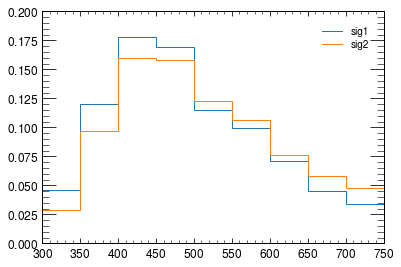

In [3]:
h = np.histogram(sig1['mHHH'], bins=np.arange(300,800,50), weights=sig1['eventWeightNorm'])
hep.histplot(h, label='sig1')

h = np.histogram(sig2['mHHH'], bins=np.arange(300,800,50), weights=sig2['eventWeightNorm'])
hep.histplot(h, label='sig2')

plt.legend()

In [75]:
class TransformerClassifier(Model):
    def __init__(self, d=32, h=4, n_embed=1, n_attblock=3, n_dense=2):
        super().__init__()
        
        self.d = d
        self.h = h
        self.n_embed = n_embed
        self.n_attblock = n_attblock
        self.n_dense = n_dense
        
        # Create multiple embedding layers
        self.embedding_layers = [
            layers.Dense(self.d, activation='relu', name=f'jet_embedding_{i+1}')
            for i in range(n_embed)
        ]
        
        # Apply layer normalization to the final embedding layer's output
        self.first_layerNormalisation = layers.LayerNormalization(name='layer_normalization_global_1')
        
        # Multiple attention blocks
        self.attentions, self.linear_layers, self.layer_normalisations1, self.layer_normalisations2 = [], [], [], []
        for block in range(self.n_attblock):
            
            # Multi-Headed Self-Attention block
            self.attentions.append(
                layers.MultiHeadAttention(num_heads=self.h, key_dim=self.d, name=f'multi_head_attention_{block+1}')
            )
            
            # Apply LayerNormalization
            self.layer_normalisations1.append(
                layers.LayerNormalization(name=f'layer_normalization_block{block+1}_1')
            )
            
            # Add multiple linear (Dense) layers, the last one without activation
            self.linear_layers.append([])
            for i in range(self.n_dense):
                activation='relu' if i < n_dense-1 else None
                self.linear_layers[block].append(
                    layers.Dense(self.d, activation=activation, name=f'linear_layer_block{block+1}_{i+1}')
                )
            
            # Apply final LayerNormalization
            self.layer_normalisations2.append(
                layers.LayerNormalization(name=f'layer_normalization_block{block+1}_2')
            )
        
        # Cross-Attention Pooling with 1 output node to convert shapes.
        self.pooling = layers.Dense(1, activation='relu', use_bias=False, name='cross_attention_pooling')

        # Final classification layer
        self.classification = layers.Dense(1, activation='sigmoid', name='classification')
        
    def call(self, inputs):
        
        x = inputs
        #multiple embedding layers
        for i in range(self.n_embed):
            x = self.embedding_layers[i](x)
        
        # Apply layer normalization to the final embedding layer's output
        x = self.first_layerNormalisation(x)
        
        # Multiple attention blocks
        for block in range(self.n_attblock):
            
            # Multi-Headed Self-Attention block
            attn = self.attentions[block](x, x, attention_mask=None)
            
            # Apply LayerNormalization
            x = self.layer_normalisations1[block](attn+x)
            
            # Add multiple linear (Dense) layers, the last one without activation
            ffn = x
            for i in range(self.n_dense):
                ffn = self.linear_layers[block][i](ffn)
        
            # Apply final LayerNormalization
            x = self.layer_normalisations2[block](ffn+x)
        
        # Cross-Attention Pooling
        pooling = self.pooling(x)
        x = tf.reduce_sum((pooling * x), axis=1)
        
        #Make classification   #use combined_output if including global variables
        logits = self.classification(x)
        
        return logits
    
    
def build_dnn_model(input_shape, hidden_units, dropout_rate=0):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [76]:
### Transformer

scaler = StandardScaler()
X = table.drop(columns=['label']).to_numpy()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], 1, X.shape[1])  #Reshape to match needs of MultiHeadAttention
Y = table['label'].to_numpy()
weights = table['eventWeightNorm'].to_numpy()

model = TransformerClassifier(d=16, h=4, n_embed=1, n_attblock=3, n_dense=1)
loss = 'binary_crossentropy'
model.compile(optimizer='adam', loss=loss, 
              metrics=['accuracy'], weighted_metrics=['accuracy'])

history = model.fit(X, Y, epochs=10, batch_size=32, 
                    sample_weight=weights, validation_split=0.15)

Epoch 1/10
157/157 [==============================] - 5s 14ms/step - loss: 2.3580e-04 - accuracy: 0.5144 - weighted_accuracy: 0.5143 - val_loss: 2.3471e-04 - val_accuracy: 0.5107 - val_weighted_accuracy: 0.4977
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 2.3445e-04 - accuracy: 0.5393 - weighted_accuracy: 0.5336 - val_loss: 2.3302e-04 - val_accuracy: 0.5469 - val_weighted_accuracy: 0.5417
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 2.2826e-04 - accuracy: 0.6038 - weighted_accuracy: 0.6030 - val_loss: 2.1841e-04 - val_accuracy: 0.6373 - val_weighted_accuracy: 0.6355
Epoch 4/10
157/157 [==============================] - 1s 9ms/step - loss: 1.9140e-04 - accuracy: 0.7413 - weighted_accuracy: 0.7439 - val_loss: 1.7201e-04 - val_accuracy: 0.7864 - val_weighted_accuracy: 0.7850
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 1.3765e-04 - accuracy: 0.8685 - weighted_accuracy: 0.8756 - val_loss: 1.1573e-04 - va

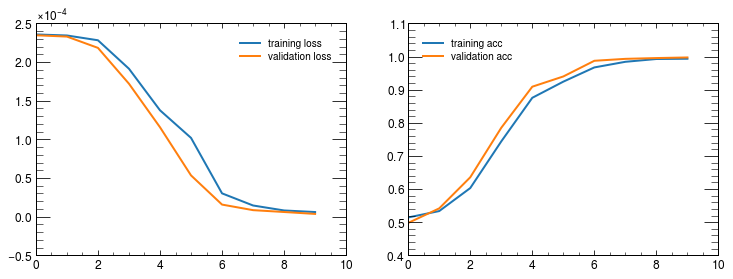

In [77]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

ax[0].plot(history.epoch, history.history['loss'], label='training loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history.epoch, history.history['weighted_accuracy'], label='training acc')
ax[1].plot(history.epoch, history.history['val_weighted_accuracy'], label='validation acc')
ax[1].legend()

In [64]:
### Standard DNN


scaler = StandardScaler()
X = table.drop(columns=['label'])
X = scaler.fit_transform(X)
Y = table['label']

# Parameters
input_shape = X.shape[1]
hidden_units = [128, 64]  # Define the number of units in each hidden layer
dropout_rate = 0.2

# Build the model
model = build_dnn_model(input_shape, hidden_units, dropout_rate)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

# Display model summary
#print(model.summary())

# Fit
history = model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.1,
                   sample_weight=table['eventWeightNorm'])

/afs/desy.de/user/g/gonzalem/myPy3env/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/afs/desy.de/user/g/gonzalem/myPy3env/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/afs/desy.de/user/g/gonzalem/myPy3env/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/afs/desy.de/user/g/gonzalem/myPy3env/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and

Epoch 1/20
166/166 [==============================] - 1s 4ms/step - loss: 2.2852e-04 - accuracy: 0.5949 - weighted_accuracy: 0.5947 - val_loss: 2.1194e-04 - val_accuracy: 0.6508 - val_weighted_accuracy: 0.6565
Epoch 2/20
166/166 [==============================] - 0s 2ms/step - loss: 1.9042e-04 - accuracy: 0.7463 - weighted_accuracy: 0.7501 - val_loss: 1.3594e-04 - val_accuracy: 0.9559 - val_weighted_accuracy: 0.9641
Epoch 3/20
166/166 [==============================] - 0s 3ms/step - loss: 1.0185e-04 - accuracy: 0.9120 - weighted_accuracy: 0.9175 - val_loss: 3.6389e-05 - val_accuracy: 0.9864 - val_weighted_accuracy: 0.9923
Epoch 4/20
166/166 [==============================] - 0s 3ms/step - loss: 3.9297e-05 - accuracy: 0.9670 - weighted_accuracy: 0.9705 - val_loss: 8.8168e-06 - val_accuracy: 0.9949 - val_weighted_accuracy: 0.9997
Epoch 5/20
166/166 [==============================] - 0s 3ms/step - loss: 1.9818e-05 - accuracy: 0.9827 - weighted_accuracy: 0.9863 - val_loss: 5.4295e-06 - val